## Classification Metrics II

---

### Learning Objectives
- Describe the inverse relationship between sensitivity and specificity.
- Construct the ROC curve.
- Understand how AUC ROC is calculated and interpret AUC ROC.
- Identify methods for handling unbalanced classes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, StandardScaler

%matplotlib inline

In [2]:
df = pd.read_csv('data/Whickham.csv')

In [3]:
df.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


- `outcome`: Whether someone is alive or dead.
- `smoker`: Whether somebody smoked or did not smoke.
- `age`: Age in years.

In [4]:
target = 'outcome'
y = df[target]
X = df.drop(target, axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
le_smoker = LabelEncoder()

Z_train, Z_test = X_train.copy(), X_test.copy()

Z_train['smoker'] = le_smoker.fit_transform(X_train['smoker'])
Z_test['smoker'] = le_smoker.transform(X_test['smoker'])

In [7]:
le_alive = LabelEncoder()

y_train = le_alive.fit_transform(y_train)
y_test = le_alive.transform(y_test)

In [8]:
y_train

array([0, 0, 1, ..., 1, 1, 0])

In [9]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
Z_train = poly.fit_transform(Z_train)
Z_test = poly.transform(Z_test)

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
model = LogisticRegression(solver='lbfgs')
model.fit(Z_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

- Read more about the solver [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [12]:
model.coef_

array([[ 0.37843747,  0.12755189, -0.00454649]])

In [13]:
np.exp(model.coef_)

array([[1.4600015 , 1.13604382, 0.99546383]])

<details><summary>How would you interpret the coefficient for age?</summary>

- As age increases by 1, someone is 1.104 times as likely to be dead.
</details>

---

<details><summary>In this situation, what term would we use to describe someone who is predicted to be dead but actually is alive? (Remember that alive is coded as 0 and dead is coded as 1.)</summary>

- We **falsely** predict someone to be **positive**.
- This would be a **false positive**.
</details>

---

<details><summary>In this situation, what is a true negative?</summary>

- We **correctly** predict someone to be **negative**.
- Someone who is predicted to be alive (`0`) and actually is alive (`0`).
</details>

In [14]:
from sklearn.metrics import confusion_matrix

<details><summary>If I want to get a good understanding of how our model will do on new data, should I generate a confusion matrix on our training or testing set? Why?</summary>
    
- Testing set!
- If we generate one on our training set, we're going to overestimate the performance of our model... just like if we calculated MSE on our training set.
</details>

In [15]:
y_test_hat = model.predict(Z_test)

In [16]:
confusion_matrix(y_test, y_test_hat)  

array([[176,  20],
       [ 27,  40]])

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_hat).ravel()


In [18]:
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.898


In [19]:
sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.597


## Relationship between Sensitivity and Specificity

In [20]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': model.predict_proba(Z_test)[:, 1]})

In [21]:
pred_df

,pred_probs,true_values
0,0.007994,0
1,0.871166,1
2,0.317067,0
3,0.068690,0
4,0.012885,0
5,0.008824,0
6,0.292161,0
7,0.043148,0
8,0.007994,0
9,0.018706,0


Text(0.5,0,'Predicted Probability that Outcome = 1')

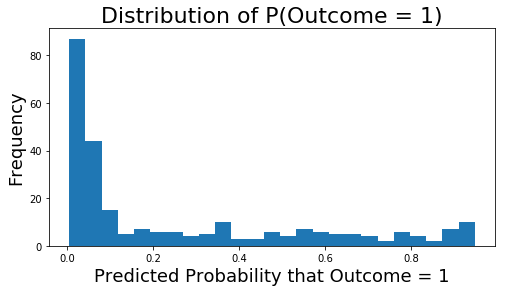

In [22]:
plt.figure(figsize = (8,4))

plt.hist(pred_df['pred_probs'], bins=25)

plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

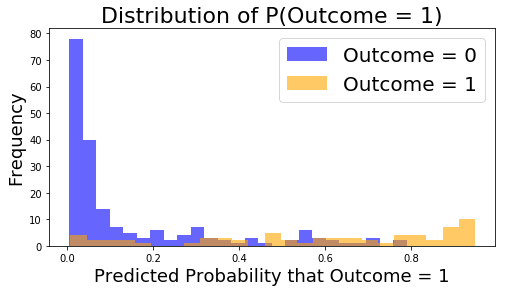

In [23]:
plt.figure(figsize = (8,4))

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

plt.legend(fontsize=20);

<details><summary>What do you notice about this distribution?</summary>

- Way more blue than orange.
- There's lots of overlap!
</details>

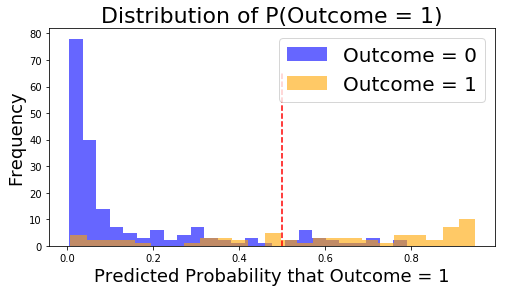

In [24]:
plt.figure(figsize = (8,4))

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

plt.legend(fontsize=20);

<details><summary>Where are my true positives, true negatives, false positives, false negatives in this image?</summary>
    
- True Positive:
    - Items I correctly predict to be positive.
    - The orange bars (actual `1`) that are to the right of the red line (predicted `1`).
- True Negative: 
    - Items I correctly predict to be negative.
    - The blue bars (actual `0`) that are to the left of the red line (predicted `0`).
- False Positive:
    - Items I incorrectly predict to be positive.
    - The blue bars (actual `0`) that are to the right of the red line (predicted `1`).
- False Negative: 
    - Items I incorrectly predict to be negative.
    - The orange bars (actual `1`) that are to the left of the red line (predicted `0`).
</details>

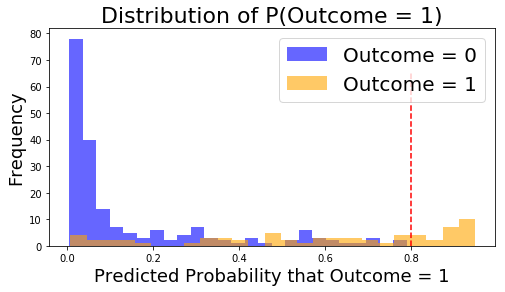

In [25]:
plt.figure(figsize = (8,4))

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

plt.vlines(x=0.8,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

plt.legend(fontsize=20);

<details><summary>When I moved my classification threshold to the left, what happened to sensitivity and specificity?</summary>

- Our number of true negatives decreased and our number of false positives went increased.
    - $\text{Sensitivity} = \frac{TN}{TN + FP} \Rightarrow \text{Sensitivity decreases.}$
- Our number of true positives increased and our number of false negatives decreased.
    - $\text{Specificity} = \frac{TP}{TP + FN} \Rightarrow \text{Specificity increases.}$
</details>

---

Our goal should be to build a model such that there is **no overlap** between the blue histogram and the orange histogram!
- If there is overlap, we need to recognize the tradeoff between sensitivity and specificity. (As one increases, the other decreases.)
- One measure of how much overlap exists between our distributions is the **area under the ROC curve**.

## Receiver Operating Characteristic (ROC) Curve

The Receiver Operating Characteristic curve is a way to visualize the overlap between our positive class and negative class by moving our classification threshold from 0 to 1.
- We start our classification threshold (dashed red line) at 0.
- We calculate sensitivity and 1 - specificity.
- We plot the value of (x = sensitivity, y = 1 - specificity).
- We increase our classification threshold a small number (like 0.005).
- We calculate sensitivity and 1 - specificity.
- We plot the value of (x = sensitivity, y = 1 - specificity).
- We repeat until our threshold is equal to 1.

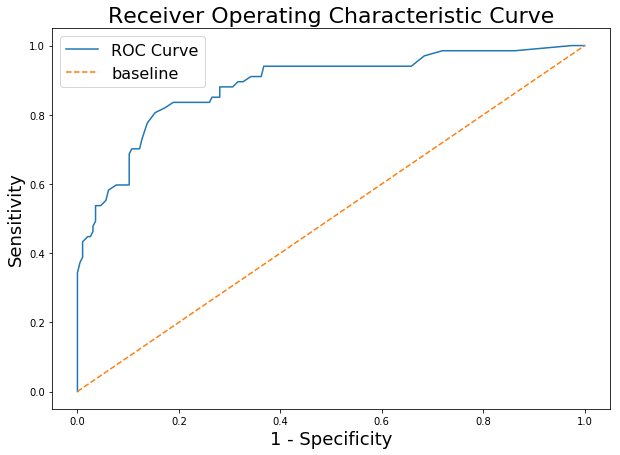

In [26]:
plt.figure(figsize = (10,7))

thresholds = np.linspace(0, 1, 200)

def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

plt.plot(fpr_values, tpr_values, label='ROC Curve')

plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

plt.legend(fontsize=16);

### AUC ROC

The more area under this blue curve is, the better separated our distributions are.
- Check out [this gif](https://twitter.com/DrHughHarvey/status/1104435699095404544).

We use the **area under the ROC curve** (abbreviated **AUC ROC**) to quantify the gap between our distributions.

<details><summary>Note: Not to be confused with the AOC ROC.</summary>
<img src="./images/AOC.jpg" alt="AOC" width="400"/>
</details>

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8856229058787694

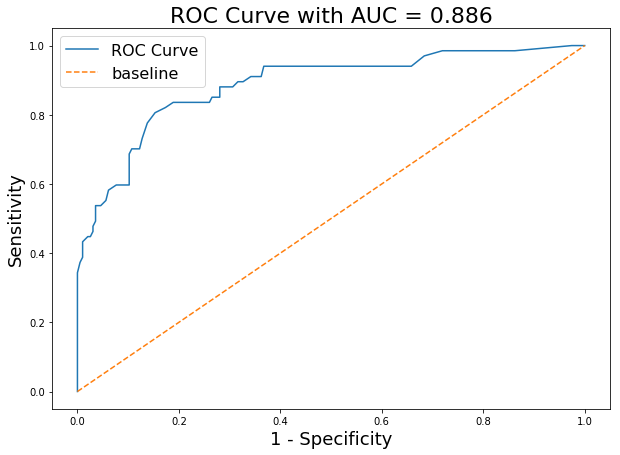

In [29]:
plt.figure(figsize = (10,7))

thresholds = np.linspace(0, 1, 200)

def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

plt.plot(fpr_values, tpr_values, label='ROC Curve')

plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

plt.legend(fontsize=16);

### Interpreting AUC ROC
- If you have an AUC ROC of 0.5, your positive and negative populations perfectly overlap and your model is as bad as it can get.
- If you have an AUC ROC of 1, your positive and negative populations are perfectly separated and your model is as good as it can get.
- The closer your AUC ROC is to 1, the better. (1 is the maximum score.)
- If you have an AUC ROC of below 0.5, your positive and negative distributions have flipped sides. By flipping your predicted values (i.e. flipping predicted 1s and 0s), your AUC ROC will now be above 0.5.
    - Example: You have an AUC ROC of 0.2. If you change your predicted 1s to 0s and your predicted 0s to 1s, your AUC ROC will now be 0.8!

We generate one ROC curve per model. The ROC curve is generated by varying our threshold from 0 to 1. This doesn't actually change the threshold or our original predictions, but it helps us to visualize our tradeoff between _sensitivity_ and _specificity_ and understand how well-separated our populations are.

### Balanced / Unbalanced Classes

Suppose I want to predict the incidence of West Nile Virus (WNV) in Chicago.
- 99.9% of my observations are "no WNV."
- 0.1% of my observations contain "WNV."

If we fit a model and tried to optimize for accuracy, I can predict "no WNV" for every location and have an accuracy score that is really, _really_ good!

<details><summary>Why is this a bad model?</summary>
    
- We'll never predict that a location has West Nile Virus, which is probably going to lead to outbreaks of the disease.
</details>

In classification problems, methods generally better when we have roughly equally-sized classes. (i.e. 50% in the positive class and 50% in the negative class for binary classification problems).

#### Methods for Dealing with Unbalanced Classes

- **Bias correction.** Gary King wrote a [great whitepaper](https://gking.harvard.edu/files/gking/files/0s.pdf) on this topic.  This is a rigorous approach and while provide good results, as data scientists we prefer "easier" methods.


- **Weighting observations.** Some models allow the weighting of classes such as linear and logistic regression, Naive Bayes, Random Forests, SVMs, etc.


- **Stratified cross-validation.** If we use $k$-fold cross-validation entirely randomly, we may run into issues where some of our folds have no observations from the minority class.

<img src="https://snag.gy/PqISr3.jpg">

By stratifying on our output variable with unbalanced classes during cross- validation, we protect ourselves from this situation and ensure that our estimate of our model performance has lower variance.


- **Changing threshold for classification.**
By adjusting our classification threshold, we might find a better fit for our particular use-case.  We performed this operation earlier by manually changing our predicted labels by choosing a new threshold from the predicted probability.


- **Purposefully optimizing evaluation metrics.**
We might also consider optimizating our model for a specific metric such as precision, recall by class, AUC ROC.

## For supplemental reading material on this topic, check out the following resources:*

- [Good Twitter Thread on AUC ROC](https://twitter.com/cecilejanssens/status/1104134423673479169)
- [.gif of ROC Curve with Distributions](https://twitter.com/DrHughHarvey/status/1104435699095404544)
- [SKLearn Documentation of AUC_ROC_Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
- [DSI-NYC Instructional Associate & Alumna Ashley Mighty - Imbalanced Classes Repo](https://github.com/aamighty/Imbalanced_Data)
- [Medium Article on Classification Model Evaluation through AUC ROC](https://towardsdatascience.com/understanding-the-roc-and-auc-curves-a05b68550b69)
- [Elite Data Science: How to Handle Imbalanced Classes in Machine Learning](https://elitedatascience.com/imbalanced-classes)
- [SKLearn Documentation for Stratified k-Fold Cross-Validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)
- [Gary King: Logistic Regression in Rare Events Data](https://gking.harvard.edu/files/0s.pdf)
- [Gary King: Webpage on Rare Event Data](https://gking.harvard.edu/category/research-interests/methods/rare-events)
- [Extreme Value Theory](https://en.wikipedia.org/wiki/Extreme_value_theory)

---